## **Import Library**

In [2]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## **Data Loading**

In [3]:
# Download dataset
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\M Ilham Ramadhan\.cache\kagglehub\datasets\arashnic\book-recommendation-dataset\versions\3


In [4]:
# Mengecek nama file
files = os.listdir(path)
print(files)

['Books.csv', 'classicRec.png', 'DeepRec.png', 'Ratings.csv', 'recsys_taxonomy2.png', 'Users.csv']


In [5]:
# Import dataset
df_books = pd.read_csv(f'{path}/Books.csv')
df_ratings = pd.read_csv(f'{path}/Ratings.csv')
df_users = pd.read_csv(f'{path}/Users.csv')

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_6396\1469713850.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(f'{path}/Books.csv')


## **Exploratory Data Analysis**

### Ratings

In [6]:
# Menampilkan informasi awal dari dataset
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


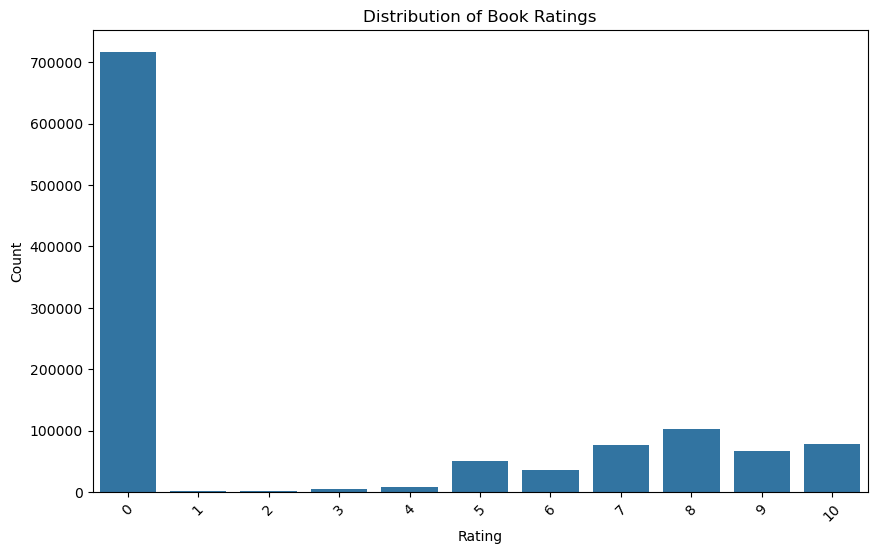

In [7]:
# Memvisualisasikan distribusi rating
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=df_ratings)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Insight**

Tabel `Ratings` merupakan inti dari sistem rekomendasi karena berisi interaksi antara pengguna dan buku dalam bentuk rating. Tabel ini menjadi dasar dalam pendekatan collaborative filtering untuk mempelajari pola kesukaan pengguna.

Kolom-kolom pada tabel ini mencakup:
- **User-ID** : ID pengguna yang memberikan rating.
- **ISBN** : ISBN buku yang dinilai.
- **Book-Rating** : Nilai rating yang diberikan pengguna terhadap buku (rentang 0–10, di mana 0 berarti tidak memberikan rating eksplisit).

Tabel `Ratings` merupakan tabel interaksi antara pengguna dan buku. Terdiri dari 1.149.780 baris dan 3 kolom, dengan nilai `Book-Rating` berupa skor dari 0 sampai 10. Rating bernilai 0 mengindikasikan bahwa pengguna tidak memberikan rating eksplisit.

Hasil visualisasi menunjukkan bahwa mayoritas pengguna cenderung memberikan rating tinggi, terutama pada nilai rentang 7 hingga 10. Sementara itu, rating rendah (1–3) relatif jarang diberikan. Distribusi ini mengindikasikan adanya bias positif dalam sistem penilaian buku, yang umum ditemukan pada data crowdsourced, di mana pengguna cenderung menilai buku yang mereka sukai.

### Books

In [8]:
# Menampilkan informasi awal dari dataset
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [9]:
# Mengecek nilai unik pada kolom 'Year-Of-Publication'
print("Unique years of publication :\n", df_books['Year-Of-Publication'].unique())

Unique years of publication :
 [2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999' '2004' '2003' '1990'
 '1994' '1986' '1989' '2002' '1981' '1993' '1983' '1982' '1976' '1991'
 '1977' '1998' '1992' '1996' '0' '1997' '2001' '1974' '1968' '1987' '1984'
 '1988' '1963' '1956' '1970' '1985' '1978' '1973' '1980' '1979' '1975'
 '1969' '1961' '1965' '1939' '1958' '1950' '1953' '1966' '1971' '1959'
 '1972' '1955' '1957' '1945' '1960' '1967' '1932' '1924' '1964' '2012'
 '1911' '1927' '1948' '1962' '2006' '1

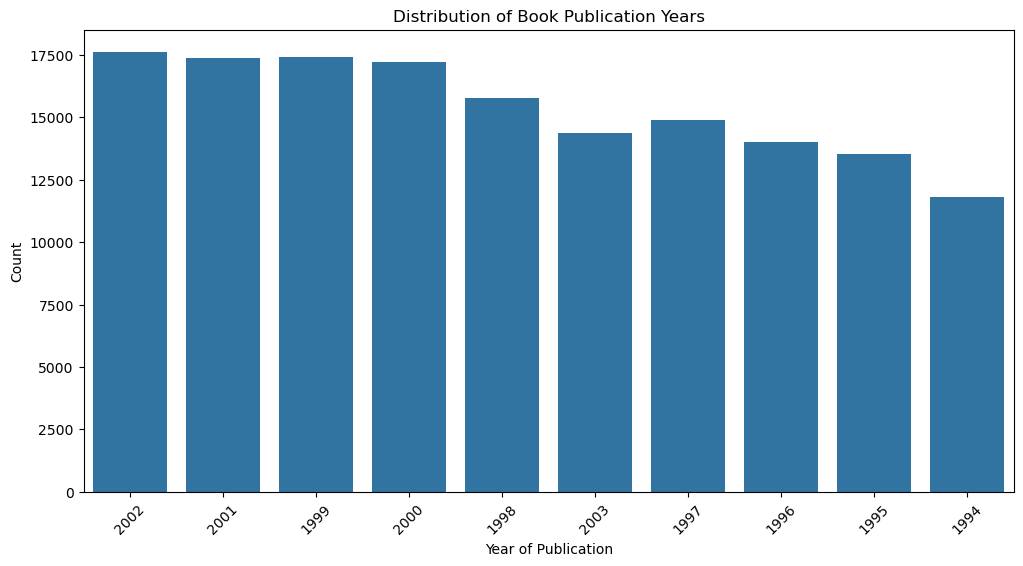

In [10]:
# Memvisualisasikan top 10 tahun dengan publikasi buku terbanyak
plt.figure(figsize=(12, 6))
sns.countplot(x='Year-Of-Publication', data=df_books, order=df_books['Year-Of-Publication'].value_counts().index[:10])
plt.title('Distribution of Book Publication Years')
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Insight**

Tabel `Books` berisi metadata terkait buku yang tersedia dalam dataset. Informasi ini berguna untuk membangun model content-based filtering karena dapat digunakan untuk menghitung kesamaan antar buku berdasarkan atribut seperti judul, penulis, dan penerbit.

Kolom-kolom pada tabel ini mencakup:
- **ISBN** : Nomor identifikasi unik untuk setiap buku (sebagai primary key).
- **Book-Title** : Judul buku.
- **Book-Author** : Nama penulis buku.
- **Year-Of-Publication** : Tahun diterbitkannya buku.
- **Publisher** : Nama penerbit buku.
- **Image-URL-S/M/L** : Link URL untuk gambar sampul buku dalam berbagai ukuran.

Tabel `Books` memiliki 271.360 entri data buku dengan 8 kolom. Kolom `ISBN` berperan sebagai identifikasi unik, dan sebagian besar kolom bertipe string. Namun, kolom `Year-Of-Publication` bertipe numerik. Beberapa data pada kolom `Year-Of-Publication` dan `Publisher` mengandung nilai tidak valid atau tidak lengkap.

Dari visualisasi tersebut terlihat bahwa sebagian besar buku dalam dataset diterbitkan antara tahun 1990 hingga awal 2000-an. Puncak publikasi terjadi pada tahun-tahun seperti 1999 dan 2002. Ini menandakan bahwa dataset memiliki fokus pada literatur modern dari dua dekade terakhir abad ke-20, yang cukup representatif untuk sistem rekomendasi buku kontemporer.

### Users

In [11]:
# Menampilkan informasi awal dari dataset
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


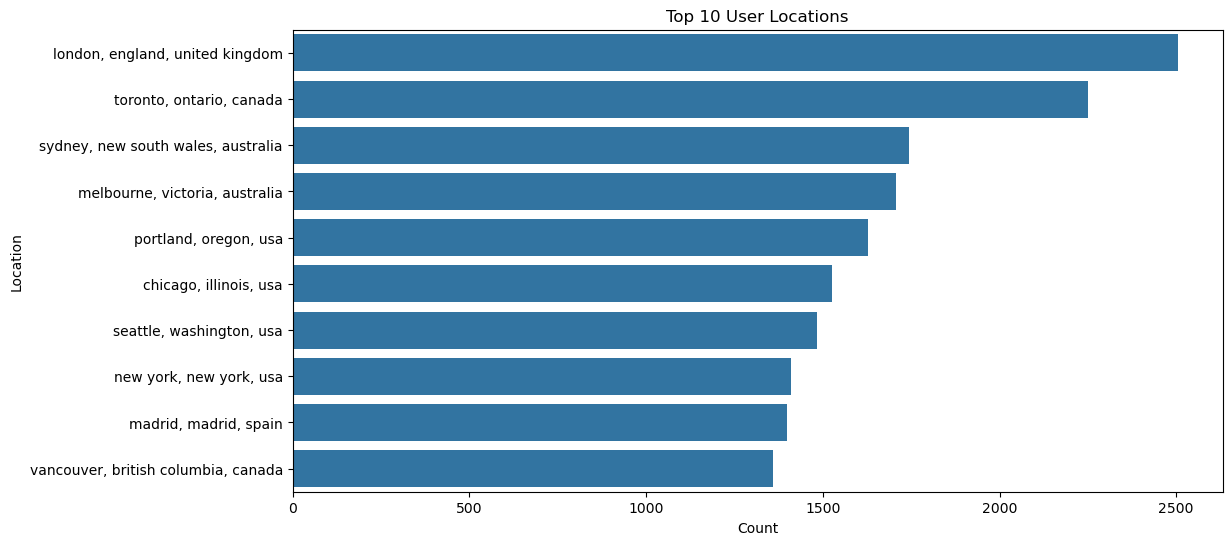

In [12]:
# Menmvisualisasikan 10 lokasi dengan jumlah pengguna terbanyak
plt.figure(figsize=(12, 6))
sns.countplot(y='Location', data=df_users, order=df_users['Location'].value_counts().index[:10])
plt.title('Top 10 User Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

**Insight**

Tabel `Users` berisi informasi dasar tentang pengguna yang memberikan rating pada buku. Informasi ini digunakan dalam collaborative filtering, terutama untuk mengelompokkan pengguna berdasarkan kesamaan preferensi.

Kolom-kolom pada tabel ini mencakup:
- **User-ID** : ID unik yang merepresentasikan setiap pengguna.
- **Location** : Informasi lokasi pengguna (biasanya terdiri dari kota, negara bagian, dan negara).
- **Age** : Usia pengguna (nilai ini bersifat opsional dan banyak mengandung missing value).

Tabel `Users` berisi 278.858 data pengguna dengan 3 kolom utama. Terdapat missing value pada kolom `Age`, dan data pada kolom `Location` memiliki format kombinasi `city, state, country`.

Visualisasi distribusi pengguna berdasarkan lokasi geografis menunjukkan bahwa sebagian besar pengguna berasal dari negara-negara dengan penetrasi internet yang tinggi, seperti Amerika Serikat, Kanada, dan Inggris. Hal ini mencerminkan distribusi penggunaan layanan berbasis buku yang cenderung terpusat di negara-negara berbahasa Inggris, yang juga menjadi target pasar utama bagi banyak sistem rekomendasi literatur digital.

## **Data Preparation**

### Data Handling

In [13]:
# Menghapus rating yang bernilai 0
df_ratings = df_ratings[df_ratings['Book-Rating'] != 0]

In [14]:
# Melakukan pembersihan data pada kolom 'Year-Of-Publication'
df_books = df_books[df_books['Year-Of-Publication'].astype(str).str.isnumeric()]
df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].astype(int)

df_books['Year-Of-Publication'] = pd.to_datetime(
    df_books['Year-Of-Publication'], format='%Y', errors='coerce'
).dt.year

invalid_years = [2026, 2030, 2037, 2038, 2050]
df_books = df_books[~df_books['Year-Of-Publication'].isin(invalid_years)]

In [15]:
# Mengambil hanya bagian negara dari kolom 'Location'
df_users['Location'] = df_users['Location'].str.split(',').str[-1].str.strip()

**Insight**

Pada tabel `Ratings`, terdapat nilai rating 0 yang menunjukkan bahwa pengguna tidak memberikan penilaian eksplisit terhadap buku tersebut. Dalam sistem rekomendasi berbasis rating, nilai 0 ini tidak memberikan kontribusi terhadap proses pelatihan model karena tidak merepresentasikan preferensi pengguna.

Kolom `Year-Of-Publication` pada tabel Books memiliki data yang tidak valid, seperti nilai berupa string yang bukan angka dan tahun-tahun di luar rentang yang masuk akal (misalnya 2026, 2030, 2037, dll). Oleh karena itu, dilakukan beberapa langkah pembersihan data, dimulai dengan memfilter nilai tahun agar hanya menyisakan data numerik yang valid, kemudian mengubah formatnya ke datetime, serta menghapus tahun yang berada di luar rentang realistis.

Kolom `Location` pada tabel `Users` berisi informasi lokasi pengguna dalam format `city, state, country`. Untuk menyederhanakan data dan hanya mengambil informasi tingkat negara, dilakukan ekstraksi bagian terakhir setelah koma sebagai representasi negara pengguna. Langkah ini bertujuan untuk memudahkan agregasi dan analisis berdasarkan wilayah pengguna jika dibutuhkan pada tahap selanjutnya, seperti pemfilteran konten berdasarkan lokasi

### Penggabungan Tabel

In [16]:
# Menggabungkan tabel df_ratings dengan df_books
ratings_books = df_ratings.merge(df_books, on='ISBN')

In [17]:
# Menggabungkan tabel dengan df_users
ratings_books_users = ratings_books.merge(df_users.drop("Age", axis=1), on="User-ID")

In [18]:
# Menyusun dataset final
df_all = ratings_books_users[['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication', 'Location', 'Book-Rating']]
df_all.head()

,User-ID,ISBN,Book-Title,Book-Author,Publisher,Year-Of-Publication,Location,Book-Rating
0,276726,0155061224,Rites of Passage,Judith Rae,Heinle,2001.0,usa,5
1,276729,052165615X,Help!: Level 1,Philip Prowse,Cambridge University Press,1999.0,croatia,3
2,276729,0521795028,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press,2001.0,croatia,6
3,276744,038550120X,A Painted House,JOHN GRISHAM,Doubleday,2001.0,usa,7
4,276747,0060517794,Little Altars Everywhere,Rebecca Wells,HarperTorch,2003.0,usa,9


**Insight**

Tabel `Ratings`, `Books`, dan `Users` bersifat relasional dan dapat di-*join* dengan tabel `Books` dan `Users` melalui kolom `ISBN` dan `User-ID` untuk membentuk dataset yang lebih kaya informasi. Dalam proyek ini, ketiga tabel digunakan untuk membangun dan mengevaluasi sistem rekomendasi yang mampu memberikan saran buku yang relevan bagi pengguna.

### Menangani Missing Value

In [19]:
# Cek missing value
print(f'Missing Value :\n{df_all.isnull().sum()}')

Missing Value :
User-ID                   0
ISBN                      0
Book-Title                0
Book-Author               2
Publisher                 2
Year-Of-Publication    5785
Location                  0
Book-Rating               0
dtype: int64


In [20]:
# Menghapus missing value
df_all.dropna(inplace=True)

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_6396\831735889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.dropna(inplace=True)


**Insight**

Setelah semua data tergabung, dilakukan pengecekan nilai yang hilang. Dari hasil pengecekan, ditemukan beberapa missing value di kolom `Book-Author`, `Publisher`, dan `Year-Of-Publication`. Oleh karena itu, dilakukan penghapusan seluruh baris yang mengandung nilai kosong dengan kode berikut.

### Menangani Data Duplikat

In [21]:
# Cek duplkasi data
print(f'Duplicate Data :\n{df_all.duplicated().sum()}')

Duplicate Data :
0


**Insight**

Setelah memastikan tidak adanya missing value, langkah berikutnya adalah memeriksa apakah terdapat baris data yang duplikat. Duplikasi dapat terjadi karena kesalahan saat pengumpulan atau penggabungan data dan bisa memengaruhi hasil analisis. Berdasarkan hasil pengecekan duplikasi data, didapatkan bahwa tidak terdapat duplikat data pada dataset sehingga tidak diperlukan penghapusan data dan bisa dilanjutkan ke analisis selanjutnya.

### Penyesuaian Data

In [22]:
df_all.columns = [
    'user_id',
    'isbn',
    'book_title',
    'book_author',
    'publisher',
    'year_of_publication',
    'location',
    'book_rating'
]

In [23]:
df_all

,user_id,isbn,book_title,book_author,publisher,year_of_publication,location,book_rating
0,276726,0155061224,Rites of Passage,Judith Rae,Heinle,2001.0,usa,5
1,276729,052165615X,Help!: Level 1,Philip Prowse,Cambridge University Press,1999.0,croatia,3
2,276729,0521795028,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press,2001.0,croatia,6
3,276744,038550120X,A Painted House,JOHN GRISHAM,Doubleday,2001.0,usa,7
4,276747,0060517794,Little Altars Everywhere,Rebecca Wells,HarperTorch,2003.0,usa,9
...,...,...,...,...,...,...,...,...
383812,276704,0743211383,Dreamcatcher,Stephen King,Scribner,2001.0,usa,7
383813,276704,0806917695,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,Sterling Publishing,1997.0,usa,5
383814,276704,1563526298,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,Longstreet Press,2000.0,usa,9
383815,276709,0515107662,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,Jove Books,1996.0,usa,10


In [24]:
df_all = df_all[:10000]

In [25]:
df_all.sample(10)

,user_id,isbn,book_title,book_author,publisher,year_of_publication,location,book_rating
7775,5517,0595175686,The Bridge,Michael Darkow,Authors Choice Press,2001.0,usa,10
6190,3827,0007134495,Parzival and the Stone from Heaven: A Grail Ro...,Lindsay Clarke,Thorsons Publishers,2002.0,usa,7
1129,277945,0312980353,Circle of Stars,Anna Lee Waldo,St. Martin's Paperbacks,2002.0,usa,8
5552,3346,0836204387,The Calvin and Hobbes Tenth Anniversary Book,Bill Watterson,Andrews McMeel Publishing,1995.0,iran,9
6843,4343,1852428112,The Sexual Life of Catherine M.,Catherine Millet,Consortium Book Sales &amp; Dist,2002.0,japan,5
8912,6323,0553285343,"RUSSIA HOUSE, THE",JOHN LE CARRE,Bantam,1990.0,usa,9
4833,2414,0451176723,Mitigating Circumstances,Nancy Taylor Rosenberg,Signet Book,1993.0,australia,5
6788,4225,1573229326,How to Be Good,Nick Hornby,Riverhead Books,2002.0,canada,5
2460,499,0743412621,The Second Time Around : A Novel,Mary Higgins Clark,Pocket,2004.0,usa,10
2042,278798,0786868015,The Diary of Ellen Rimbauer: My Life at Rose Red,Joyce Reardon,Hyperion,2001.0,usa,7


In [26]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 10164
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              10000 non-null  int64  
 1   isbn                 10000 non-null  object 
 2   book_title           10000 non-null  object 
 3   book_author          10000 non-null  object 
 4   publisher            10000 non-null  object 
 5   year_of_publication  10000 non-null  float64
 6   location             10000 non-null  object 
 7   book_rating          10000 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 703.1+ KB


**Insight**

Agar nama kolom menjadi lebih seragam dan sesuai dengan konvensi penulisan Python (menggunakan lowercase dan underscore), maka dilakukan pengubahan nama kolom. Pengubahan ini sangat penting untuk meningkatkan keterbacaan dan konsistensi penamaan kolom dalam proses analisis berikutnya. Penamaan yang rapi akan mempermudah dalam pemanggilan kolom menggunakan kode dan meminimalkan kesalahan penulisan variabel. 

Dataset yang dimiliki sekarang memiliki jumlah data yang sangat besar dan berpotensi membuat proses analisis dan pelatihan model menjadi lambat. Oleh karena itu, untuk keperluan eksperimen awal dan efisiensi komputasi, dataset ini dipotong menjadi 10.000 baris pertama. Pembatasan ini tidak memengaruhi validitas analisis selama distribusi data yang diambil tetap representatif. Nantinya, jika dibutuhkan, jumlah data dapat ditambah secara bertahap untuk meningkatkan akurasi sistem rekomendasi.

### TF-IDF

In [27]:
# Menggabungkan kolom untuk representasi teks
df_all['content'] = (
    df_all['book_title'].astype(str) + ' ' +
    df_all['book_author'].astype(str)
)

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_6396\699463358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['content'] = (


In [28]:
# Melakukan TF-IDF pada kolom 'content'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_all['content'])
tfidf_matrix.shape

tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
# Mengubah matriks TF-IDF menjadi dataframe
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=list(tfidf.vocabulary_.keys()),
    index = df_all.book_title
).sample(5)

,rites,passage,judith,rae,help,level,philip,prowse,amsterdam,connection,...,manors,blouse,certainty,connors,yonder,pity,killers,glance,cawthorne,sunburned
book_title,,,,,,,,,,,,,,,,,,,,,
Lucy's Treasure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Professional Photoshop: Color Correction, Retouching, and Image Manipulation With Adobe Photoshop",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Holes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
My Antonia (Dover Thrift Editions),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Cardinal of the Kremlin (Jack Ryan Novels),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Insight**

Langkah pertama adalah membangun fitur teks yang mewakili isi atau deskripsi dari sebuah buku. Fitur ini dibentuk dari gabungan beberapa kolom yaitu `book_title` dan `book_author`. Hasil dari kolom `content` adalah representasi teks dari setiap buku yang akan digunakan untuk mengukur kemiripan satu sama lain. 

Setelah kolom `content` dibuat, langkah selanjutnya adalah mengubah teks menjadi representasi numerik menggunakan TF-IDF (Term Frequency-Inverse Document Frequency). 

Berikut adalah penjelasan kode transformasi dengan TF-IDF tersebut.

- `TfidfVectorizer` mengubah teks menjadi matriks angka berbasis frekuensi kata yang distandarisasi.

- Parameter `stop_words='english'` berguna untuk mengabaikan kata-kata umum (seperti "and", "the", dll).

- `tfidf_matrix.shape` menunjukkan dimensi dari hasil transformasi. Pada data tersebut didapatkan shape (10000, 14137) yang berarti ada 10.000 buku dan 14.137 kata unik (fitur).

Langkah selanjutnya adalah membentuk tabel yang menunjukkan nilai bobot TF-IDF untuk beberapa judul buku terhadap kata-kata tertentu. Nilai yang lebih tinggi menunjukkan kata tersebut lebih relevan untuk buku tersebut.

### Encoding dan Data Splitting

In [33]:
# Mengambil ID unik pengguna dan buku
user_ids = df_all['user_id'].unique().tolist()
isbn_ids = df_all['isbn'].unique().tolist()

In [34]:
# Encoding ID pengguna dan buku
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_ids)}
user_encoded_to_user = {i: x for x, i in user_to_user_encoded.items()}
isbn_encoded_to_isbn = {i: x for x, i in isbn_to_isbn_encoded.items()}

In [35]:
# Mapping encoding ke dataset utama
df_all['user'] = df_all['user_id'].map(user_to_user_encoded)
df_all['book'] = df_all['isbn'].map(isbn_to_isbn_encoded)

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_6396\3082041156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['user'] = df_all['user_id'].map(user_to_user_encoded)
C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_6396\3082041156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['book'] = df_all['isbn'].map(isbn_to_isbn_encoded)


In [36]:
# Konversi dan normalisasi rating
df_all['book_rating'] = df_all['book_rating'].values.astype(np.float32)

min_rating = df_all['book_rating'].min()
max_rating = df_all['book_rating'].max()

df_all = df_all.sample(frac=1, random_state=42)
x = df_all[['user', 'book']].values
y = df_all['book_rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_6396\3667994213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['book_rating'] = df_all['book_rating'].values.astype(np.float32)


In [37]:
# Data splitting
train_indices = int(0.8 * df_all.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

**Insight**

Sebelum membangun model Collaborative Learning, langkah-langkah pra-pemrosesan dilakukan untuk mengubah data mentah menjadi format numerik yang dapat digunakan dalam training.

- Langkah pertama adalah mengekstrak semua ID unik dari kolom `user_id` dan `isbn`. 

- Setelah itu, ditemukan bahwa ID pengguna dan buku masih berbentuk string. Model deep learning membutuhkan input numerik, sehingga perlu dilakukan proses encoding dengan kode berikut. 

- Setelah mendapatkan mapping ID ke angka, kita terapkan hasil encoding tersebut ke dataset utama agar model dapat mengenali setiap entitas pengguna dan buku dalam bentuk numerik. 

- Langkah berikutnya adalah memastikan bahwa rating memiliki format numerik yang sesuai dan kemudian melakukan normalisasi ke skala 0–1. Setelah itu dilakukan konversi ke float32 memastikan efisiensi komputasi dan kompatibilitas dengan TensorFlow. Kemudian diambil nilai minimum dan maksimum dari rating, karena kita akan melakukan min-max normalization.

- Langkah terakhir dalam persiapan data adalah membagi dataset menjadi dua bagian yaitu data pelatihan dan data validasi. Pembagian ini penting untuk mengevaluasi performa model terhadap data yang belum pernah dilihat sebelumnya. Dengan membagi data, kita bisa mengetahui apakah model benar-benar belajar dari data atau hanya sekadar menghafal (overfitting).

## **Content-Based Filtering**

### Cosine Similarity

In [30]:
# Menghitung kemiripan antar buku dengan Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_all['book_title'], columns=df_all['book_title'])

print('Shape :\n', cosine_sim_df.shape)

Shape :
 (10000, 10000)


**Insight**

Setelah vektorisasi, dilakukan perhitungan kemiripan antar buku dengan Cosine Similarity, yaitu ukuran sudut antar vektor teks. Semakin kecil sudutnya (mendekati 1), semakin mirip dua buku tersebut.


Dari kode yang telah diterapkan dapat dijelaskan bahwa variabel `cosine_sim` adalah matriks 2D (10000 x 10000) yang menunjukkan tingkat kemiripan antar semua kombinasi buku. Nilai dari diagonalnya pasti bernilai 1 karena setiap buku pasti mirip dengan dirinya sendiri. Sedangkan pembuatan `cosine_sim_df` mempermudah pencarian dan visualisasi skor kemiripan berdasarkan judul.

### Recommendation

In [31]:
# Membuat fungsi untuk mendapatkan rekomendasi buku
def recommend_books_by_title(book_title, similarity_data=cosine_sim_df, book_data=df_all[['book_title', 'book_author', 'publisher', 'year_of_publication']], top_n=5):
    if book_title not in similarity_data.columns:
        return f"Book '{book_title}' not found in similarity data."

    similarity_scores = similarity_data[book_title].nlargest(20)
    similarity_scores = similarity_scores.drop(book_title, errors='ignore')

    result = pd.DataFrame({
        'book_title': similarity_scores.index,
        'similarity': similarity_scores.values
    })

    result = result.merge(book_data, on='book_title', how='left')
    result = result.drop_duplicates(subset='book_title')

    return result[['book_title', 'book_author', 'publisher', 'year_of_publication', 'similarity']].head(top_n)

In [32]:
# Mencari rekomendasi buku berdasarkan judul buku tertentu
recommend_books_by_title('Scooby-Doo on Zombie Island (Scooby-Doo)')

,book_title,book_author,publisher,year_of_publication,similarity
0,"The Racecar Monster (Scooby-Doo Picture Clue, 8)",Gail Herman,Scholastic,2001.0,0.626506
1,Zombie!,Peter Tremayne,St. Martin's Press,1987.0,0.190324
2,WINDS OF WAR,Herman Wouk,Pocket,1989.0,0.139092
3,Tested By Fire (Baxter Series),Kathy Herman,Multnomah,2001.0,0.128505
4,Night of Many Dreams : A Novel,Gail Tsukiyama,St. Martin's Griffin,1998.0,0.123376


**Insight**

`recommend_books_by_title()` menggunakan content-based filtering dengan menghitung kemiripan antar buku menggunakan TF-IDF dan cosine similarity. Buku yang direkomendasikan didasarkan pada kesamaan konten (judul, penulis, lokasi) dengan buku input. Berikut adalah contoh pengimplementasiannya mencari rekomendasi berdasarkan suatu buku.

Dari contoh mencari rekomendasi buku berdasarkan buku "Scooby-Doo on Zombie Island", sistem merekomendasikan buku lain seperti "The Racecar Monster" dari seri Scooby-Doo dengan skor kemiripan tertinggi (0.627), serta buku bertema serupa seperti "Zombie!" dan "WINDS OF WAR". Rekomendasi ini membantu pengguna menemukan buku yang mirip secara konten.

## **Collaborative Filtering**

### RecommenderNet

In [38]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(num_books, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])

        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        x = dot_user_book + user_bias + book_bias

        return tf.nn.sigmoid(x)

In [39]:
num_users = len(user_to_user_encoded)
num_books = len(isbn_to_isbn_encoded)

In [40]:
model = RecommenderNet(num_users, num_books, embedding_size=50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [41]:
history = model.fit(x=x_train, y=y_train, batch_size=16, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6876 - root_mean_squared_error: 0.3129 - val_loss: 0.6718 - val_root_mean_squared_error: 0.2972
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5954 - root_mean_squared_error: 0.2313 - val_loss: 0.6620 - val_root_mean_squared_error: 0.2887
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5671 - root_mean_squared_error: 0.2047 - val_loss: 0.6620 - val_root_mean_squared_error: 0.2888
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5523 - root_mean_squared_error: 0.1873 - val_loss: 0.6576 - val_root_mean_squared_error: 0.2850
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5550 - root_mean_squared_error: 0.1874 - val_loss: 0.6556 - val_root_mean_squared_error: 0.2834
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5472 - root_mean_squared_error: 0.1828 - val_loss: 0.6516 - val_root_mean_squared_error: 0.2801
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step 

In [42]:
def recommend_books_for_user(user_id, top_n=5):
    user_books = df_all[df_all.user_id == user_id]
    books_read = user_books['isbn'].values

    unread_books = df_all[~df_all['isbn'].isin(books_read)]['isbn'].unique()

    unread_books_encoded = [isbn_to_isbn_encoded.get(x) for x in unread_books if x in isbn_to_isbn_encoded]
    user_encoded = user_to_user_encoded.get(user_id)

    user_book_array = np.hstack(([[user_encoded]] * len(unread_books_encoded), np.array(unread_books_encoded).reshape(-1, 1)))
    
    ratings = model.predict(user_book_array).flatten()
    top_indices = ratings.argsort()[-top_n:][::-1]

    top_isbn = [isbn_encoded_to_isbn[i] for i in np.array(unread_books_encoded)[top_indices]]

    recommended_books = df_all[df_all['isbn'].isin(top_isbn)][['isbn', 'book_title', 'book_author', 'publisher']].drop_duplicates()

    print(f"\nTop {top_n} book recommendations for User ID: {user_id}\n")
    for row in recommended_books.itertuples():
        print(f"{row.book_title} — {row.book_author} ({row.publisher})")


In [43]:
recommend_books_for_user(user_id=1234, top_n=10)

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Top 10 book recommendations for User ID: 1234

A Wrinkle in Time — Madeleine L'Engle (Laure Leaf)
The Unknown Errors of Our Lives: Stories — Chitra Banerjee Divakaruni (Anchor Books/Doubleday)
The Secret Life of Bees — Sue Monk Kidd (Penguin Books)
The Da Vinci Code — Dan Brown (Doubleday)
To Kill a Mockingbird — Harper Lee (Little Brown &amp; Company)
Harry Potter and the Goblet of Fire (Book 4) — J. K. Rowling (Scholastic)
The Last Juror — John Grisham (Doubleday)
Harry Potter and the Prisoner of Azkaban (Book 3) — J. K. Rowling (Scholastic)
The Giver (21st Century Reference) — LOIS LOWRY (Laure Leaf)
Cold Mountain : A Novel — CHARLES FRAZIER (Vintage)


**Insight**

Model Collaborative Filtering yang dibangun menggunakan TensorFlow Keras dan terdiri dari arsitektur embedding untuk pengguna dan item (dalam hal ini buku). Tujuan utamanya adalah mempelajari representasi vektor (embedding) dari pengguna dan item, lalu menghitung skor kesukaan melalui operasi dot product. Berikut adalah kode dari permodelan yag digunakan.

Model RecommenderNet yang digunakan terdiri dari beberapa komponen berikut

- `Embedding(num_users, embedding_size)`  
Mengkonversi ID pengguna menjadi representasi vektor berdimensi embedding_size.

- `Embedding(num_items, embedding_size)`  
Mengkonversi ID buku menjadi vektor embedding berdimensi sama.

- `dot_user_item + user_bias + item_bias`  
Skor kesukaan dihitung sebagai hasil dot product vektor pengguna dan buku ditambah bias masing-masing.

- `sigmoid`  
Fungsi aktivasi sigmoid membatasi output ke rentang 0–1.

Setelah model dibangun, langkah selanjutnya adalah melakukan kompilasi dan pelatihan terhadap model dengan data pelatihan. Berikut adalah beberapa parameter yang digunakan dan penjelasan dari parameternya.

- `loss='binary_crossentropy'`  
Digunakan karena rating telah dinormalisasi ke 0–1 (mirip klasifikasi biner).

- `optimizer='adam'`  
Optimizer adaptif yang efisien dan umum digunakan.

- `metrics=['RootMeanSquaredError']`
Digunakan untuk mengukur deviasi prediksi terhadap nilai asli dalam bentuk kuadrat akar.

- `train_data, train_ratings`  
Data input dan target berupa pasangan user-item dan skor kesukaan.

- `batch_size=64`  
Jumlah data yang diproses dalam satu iterasi.

- `epochs=20`  
Jumlah putaran penuh pelatihan terhadap seluruh data.

- `validation_data`  
Data validasi digunakan untuk memantau generalisasi model.

Setelah model selesai dilatih, digunakan fungsi prediksi untuk merekomendasikan buku kepada pengguna berdasarkan skor tertinggi dari buku yang belum pernah dibaca. Dengan melakukan prediksi rekomendasi terhadap user '1234' didapatkan kesimpulan bahwa model ini memberikan rekomendasi berdasarkan kesamaan pola interaksi dengan pengguna lain yang memiliki preferensi serupa, tanpa memerlukan informasi konten eksplisit dari buku atau profil pengguna.

## **Evaluasi**

In [45]:
def evaluate_recommendation(recommendations, test_book_title, df, top_n=5):
    test_author = df[df['book_title'] == test_book_title]['book_author'].values[0]

    recommended_authors = recommendations['book_author'].tolist()
    relevant_recommended = sum([1 for author in recommended_authors if author == test_author])

    total_relevant = len(df[(df['book_author'] == test_author) & (df['book_title'] != test_book_title)])

    precision = relevant_recommended / top_n
    recall = relevant_recommended / total_relevant if total_relevant > 0 else 0

    f1 = 0
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

In [46]:
test_book_title = 'Scooby-Doo on Zombie Island (Scooby-Doo)'

recs = recommend_books_by_title(test_book_title, top_n=5)

precision, recall, f1 = evaluate_recommendation(recs, test_book_title, df_all)

print(f"Evaluation for '{test_book_title}'")
print(f"Precision@5 : {precision:.4f}")
print(f"Recall@5    : {recall:.4f}")
print(f"F1-Score    : {f1:.4f}")

Evaluation for 'Scooby-Doo on Zombie Island (Scooby-Doo)'
Precision@5 : 0.2000
Recall@5    : 1.0000
F1-Score    : 0.3333


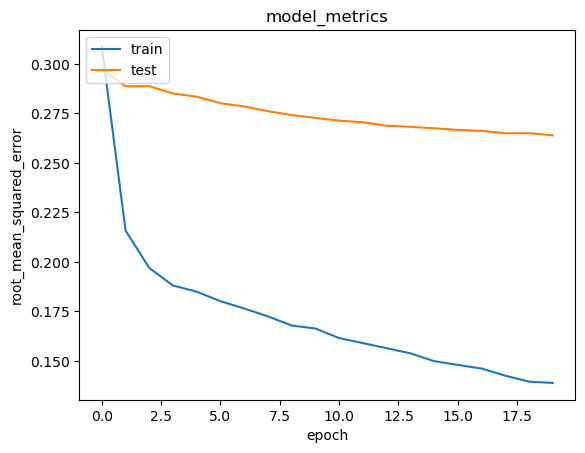

In [47]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# Evaluasi model pada data validasi
results = model.evaluate(x_val, y_val, verbose=1)

# Tampilkan hasil RMSE
print(f"RMSE on validation data: {results[1]:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6257 - root_mean_squared_error: 0.2658  
RMSE on validation data: 0.2615


**Insight**

Berdasarkan evaluasi terhadap model Content-Based Filtering didapatkan evaluasi sebagai berikut.

- **Precision@5 = 0.2000**  
  Dari 5 buku yang direkomendasikan, hanya 1 yang benar-benar relevan. Ini menunjukkan masih banyak rekomendasi yang tidak relevan.

- **Recall@5 = 1.0000**  
  Semua item yang dianggap relevan berhasil ditemukan dalam 5 rekomendasi. Ini menandakan sistem tidak melewatkan item relevan.

- **F1-Score = 0.3333**  
  Nilai F1 yang rendah menunjukkan bahwa meskipun recall tinggi, precision yang rendah menurunkan efektivitas keseluruhan sistem.

Berdasarkan evaluasi yang telah dilakukan, dapat disimpulkan bahwa Content-based model mampu menemukan semua item relevan, tapi perlu peningkatan pada kualitas ranking untuk meminimalkan rekomendasi yang tidak relevan.

Sedangkan untuk evaluasi Collaborative Filtering, berdasarkan grafik evaluasi tersebut dapat diambil beberapa informasi sebagai berikut.
- RMSE Training menurun secara signifikan hingga stabil yang berarti model mampu belajar pola dari data.
- RMSE Testing menurun perlahan dan stabil, tetapi tidak sebaik training yang mengindikasikan adanya *gap* kecil antara performa training dan testing (kemungkinan overfitting ringan).
- Tidak ada kenaikan tajam yang berarti tidak ada gejala underfitting atau overfitting parah.

Dari evaluasi yang telah dilakukan, dapat disimpulkan bahwa model Collaborative Filtering menunjukkan kinerja yang cukup baik dan stabil pada data test. Berdasarkan pengujian menggunakan data validasi, diperoleh nilai RMSE sebesar 0.2615, yang menunjukkan tingkat galat prediksi yang cukup rendah. Untuk meningkatkan performa lebih lanjut, dapat dipertimbangkan penggunaan regularisasi, model matrix factorization lainnya seperti SVD++ atau ALS, maupun pendekatan hybrid dengan content-based filtering.
